In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount ('/content/drive')

datasheet = '/content/drive/My Drive/Datasheet/DDoS/dataset_sdn.csv'
df = pd.read_csv(datasheet)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Cek Missing Values Kolom
print("Jumlah Missing Values :")
print(df.isnull().sum())

Jumlah Missing Values :
dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64


**PREPROCESSING**

In [4]:
# Drop Missing Values
df = df.dropna(subset=['rx_kbps','tot_kbps'])
print(df.isnull().sum())

dt             0
switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64


In [5]:
df.columns

Index(['dt', 'switch', 'src', 'dst', 'pktcount', 'bytecount', 'dur',
       'dur_nsec', 'tot_dur', 'flows', 'packetins', 'pktperflow',
       'byteperflow', 'pktrate', 'Pairflow', 'Protocol', 'port_no', 'tx_bytes',
       'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps', 'label'],
      dtype='object')

In [ ]:
Features = ['dt','dur','dur_nsec','tot_dur','pktrate','Protocol',
            'port_no', 'tx_kbps','rx_kbps','tot_kbps']
df_clean = df[Features]

In [8]:
numeric_feat = ['dt','dur','dur_nsec','tot_dur','pktrate','port_no','tx_kbps','rx_kbps','tot_kbps']
categorial_feat = ['Protocol']

In [9]:
# Membagi data dengan komposisi X = 80% dan y = 20% untuk model
from sklearn.model_selection import train_test_split

X = df_clean
y = df['label']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
# Menghitung rasio untuk imbalance
ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])
print("Ratio class imbalance (0/1)",ratio)

#Hasilnya akan menunjukkan Kelas 0(Normal) ada 1,56x lebih banyak daripada kelas 1(DDoS) di training set

Ratio class imbalance (0/1) 1.5636823750887263


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_features = numeric_feat
num_tranform = scaler

In [13]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder_cat = categorial_feat
encoder_tranform = encoder

In [14]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', num_tranform, num_features),
    ('cat', encoder_tranform, encoder_cat)
], remainder='drop')

In [18]:
# Membuat base Model LightGBM
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    objective='binary',
    metric ='auc',
    boosting_type ='gbdt',
    num_leaves = 31,
    learning_rate = 0.05,
    n_estimators= 1000,
    scale_pos_weight=ratio, #Uncomment jika ingin menangani imbalance
    random_state=42,
    n_jobs=-1
)

In [19]:
from sklearn.pipeline import Pipeline

lbgm_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', model)
])

**HYPERPARAMETER TUNING**

In [20]:
from scipy.stats import randint, uniform

param_distrib = {
    'classifier__n_estimators': randint(100, 600),
    'classifier__num_leaves': randint(20, 100),
    'classifier__max_depth': randint(3,15),
    'classifier__learning_rate': uniform(0.01,0.2),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__reg_alpha': uniform(0,1),
    'classifier__reg_lambda':uniform(0,1)
}

In [21]:
from sklearn.model_selection import RandomizedSearchCV

random_searchlbgm = RandomizedSearchCV(
    estimator=lbgm_pipeline,
    param_distributions=param_distrib,
    n_iter = 15,
    cv = 5,
    scoring= 'accuracy',
    verbose= 2,
    random_state=42,
    n_jobs=-1


)

In [22]:
random_searchlbgm.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[LightGBM] [Info] Number of positive: 32403, number of negative: 50668
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 83071, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390064 -> initscore=-0.447044
[LightGBM] [Info] Start training from score -0.447044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['dt',
                                                                                'dur',
                                                                                'dur_nsec',
                                                                                'tot_dur',
                                                                                'pktrate',
                                                                                'port_no',
                                                                                'tx_kbps',
                                                                                'rx_kbps',
                                                                                'tot_kbps']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['Protocol'])])),
                                             ('classifier',
                                              LGBMClassifier(learning_rate=0.05,
                                                             metric='auc',...
                                        'classifier__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b29b8550530>,
                                        'classifier__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b29b8550380>,
                                        'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b29b9142ba0>},
                   random_state=42, scoring='accuracy', verbose=2)

In [23]:
print('Best params yang ditemukan :', random_searchlbgm.best_params_)
print('Best CV Score yang ditemukan :', random_searchlbgm.best_score_)

Best params yang ditemukan : {'classifier__colsample_bytree': np.float64(0.8099098641033556), 'classifier__learning_rate': np.float64(0.08997219434305109), 'classifier__max_depth': 14, 'classifier__n_estimators': 287, 'classifier__num_leaves': 99, 'classifier__reg_alpha': np.float64(0.23277134043030423), 'classifier__reg_lambda': np.float64(0.0906064345328208), 'classifier__subsample': np.float64(0.8473544037332349)}
Best CV Score yang ditemukan : 0.9991332719730188


**EVALUATE**

In [25]:
best_model_lbgm = random_searchlbgm.best_estimator_

In [26]:
print(best_model_lbgm)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['dt', 'dur', 'dur_nsec',
                                                   'tot_dur', 'pktrate',
                                                   'port_no', 'tx_kbps',
                                                   'rx_kbps', 'tot_kbps']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Protocol'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=np.float64(0.8099098641033556),
                                learning_rate=np.float64(0.08997219434305109),
                                max_depth=14, metric='auc', n_estimators=287,
                           

In [29]:
# Pengujian menggunakan dataset training
from sklearn.metrics import accuracy_score

y_pred_train = best_model_lbgm.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print(f"Akurasi model dengan dataset training :{acc_train:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Akurasi model dengan dataset training :0.9999


In [30]:
y_pred_test = best_model_lbgm.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
print(f"Akurasi model dengan dataset test : {acc_test:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Akurasi model dengan dataset test : 0.9997


In [31]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12667
           1       1.00      1.00      1.00      8101

    accuracy                           1.00     20768
   macro avg       1.00      1.00      1.00     20768
weighted avg       1.00      1.00      1.00     20768



In [34]:
# Validasi akurasi dengan cross validation
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model_lbgm, X,y, cv=kf)
print(scores.mean())


[LightGBM] [Info] Number of positive: 32349, number of negative: 50722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 83071, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389414 -> initscore=-0.449777
[LightGBM] [Info] Start training from score -0.449777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 32465, number of negative: 50606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 83071, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390810 -> initscore=-0.443908
[LightGBM] [Info] Start training from score -0.443908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 32298, number of negative: 50773
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 83071, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388800 -> initscore=-0.452359
[LightGBM] [Info] Start training from score -0.452359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 32356, number of negative: 50715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 83071, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389498 -> initscore=-0.449422
[LightGBM] [Info] Start training from score -0.449422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 32548, number of negative: 50524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 83072, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391805 -> initscore=-0.439733
[LightGBM] [Info] Start training from score -0.439733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.9995570084671938


In [35]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model_lbgm, X, y, cv=skf)
print("Mean CV Accuracy:", scores.mean())


[LightGBM] [Info] Number of positive: 32403, number of negative: 50668
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 83071, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390064 -> initscore=-0.447044
[LightGBM] [Info] Start training from score -0.447044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 32403, number of negative: 50668
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 83071, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390064 -> initscore=-0.447044
[LightGBM] [Info] Start training from score -0.447044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 32403, number of negative: 50668
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 83071, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390064 -> initscore=-0.447044
[LightGBM] [Info] Start training from score -0.447044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 32403, number of negative: 50668
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 83071, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390064 -> initscore=-0.447044
[LightGBM] [Info] Start training from score -0.447044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 32404, number of negative: 50668
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 83072, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390071 -> initscore=-0.447013
[LightGBM] [Info] Start training from score -0.447013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Mean CV Accuracy: 0.9995184862747827


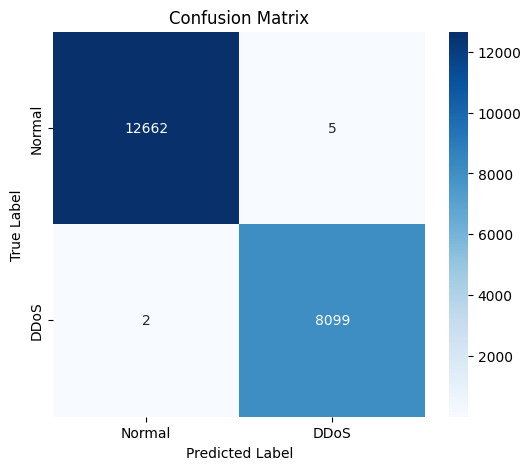

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

label = ['Normal','DDoS']
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels= label)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [38]:
model_lbgm = best_model_lbgm.named_steps['classifier'] # Ambil model lbgm
preprocessor_fit = best_model_lbgm.named_steps['preprocess'] # Ambil nama fitur dari pipeline

In [42]:
feature_importances = model_lbgm.feature_importances_
all_feature = preprocessor_fit.get_feature_names_out()

importances_df = pd.DataFrame({
    'Feature' : all_feature,
    'Importances' : feature_importances
}).sort_values(by='Importances', ascending=False)
print(importances_df.head(10))

              Feature  Importances
0             num__dt         6810
2       num__dur_nsec         6796
1            num__dur         3462
4        num__pktrate         2296
3        num__tot_dur         1924
8       num__tot_kbps          697
7        num__rx_kbps          392
6        num__tx_kbps          342
5        num__port_no          299
9  cat__Protocol_ICMP          281


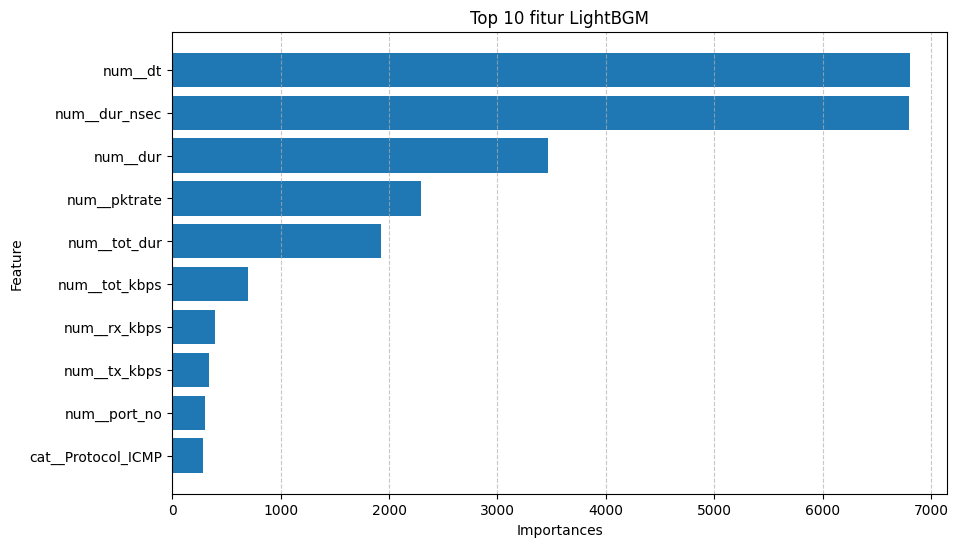

In [44]:
# Visualisasi

top_fitur = importances_df.head(10)

plt.figure(figsize=(10,6))
plt.barh(top_fitur['Feature'],top_fitur['Importances'])
plt.gca().invert_yaxis()
plt.title('Top 10 fitur LightBGM')
plt.xlabel('Importances')
plt.ylabel('Feature')
plt.grid(axis = 'x', linestyle='--', alpha=0.7)
plt.show()

In [46]:
import joblib
joblib.dump(best_model_lbgm, 'lightbgm_detectionDDoS.pkl')

['lightbgm_detectionDDoS.pkl']

In [47]:
from google.colab import files
files.download('lightbgm_detectionDDoS.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>